In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [42]:
from google.colab import drive
drive.mount('/content/drive')

# Path to directories
path = '/content/drive/MyDrive/TFM - Neural ODEs/Neural ODE/df.csv'

# Read data
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv(path, sep=',', index_col='datetime', parse_dates=['datetime'], date_parser=date_parser)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-42-f9765ec2bc53>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')


,demand,wind,price,day_of_week
datetime,,,,
2018-01-01 00:00:00,22718.1,11487.7,6.74,7
2018-01-01 01:00:00,21510.8,10123.2,4.74,7
2018-01-01 02:00:00,19865.8,8763.5,3.66,7
2018-01-01 03:00:00,19248.3,5661.2,2.30,7
2018-01-01 04:00:00,18632.1,5689.0,2.30,7


In [43]:
df = df[['price']]
df

,price
datetime,
2018-01-01 00:00:00,6.74
2018-01-01 01:00:00,4.74
2018-01-01 02:00:00,3.66
2018-01-01 03:00:00,2.30
2018-01-01 04:00:00,2.30
...,...
2022-12-31 19:00:00,18.11
2022-12-31 20:00:00,7.60
2022-12-31 21:00:00,3.69


In [44]:
# Training set. From Wednesday to Wednesday: 14 months
train_df = df.loc['2018-03-07 00:00':'2019-04-24 23:00']
train_spot = train_df.values
train_df

,price
datetime,
2018-03-07 00:00:00,41.83
2018-03-07 01:00:00,39.80
2018-03-07 02:00:00,37.81
2018-03-07 03:00:00,37.61
2018-03-07 04:00:00,37.54
...,...
2019-04-24 19:00:00,39.45
2019-04-24 20:00:00,42.08
2019-04-24 21:00:00,49.59


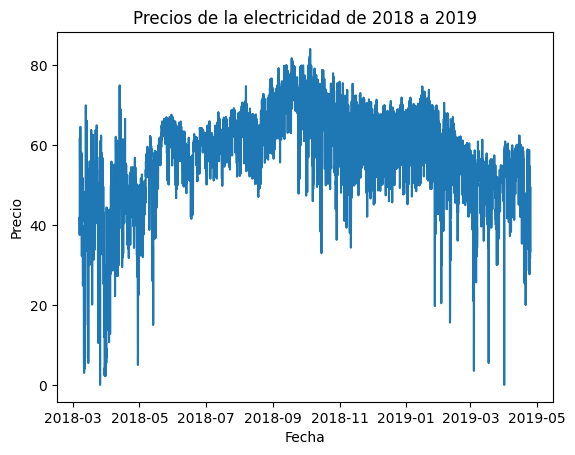

In [45]:
import matplotlib.pyplot as plt

# Crear una figura y un eje
fig, ax = plt.subplots()

# Graficar los datos
ax.plot(train_df.index, train_df['price'])

# Añadir título y etiquetas
ax.set_title('Precios de la electricidad de 2018 a 2019')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio')

# Mostrar la gráfica
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


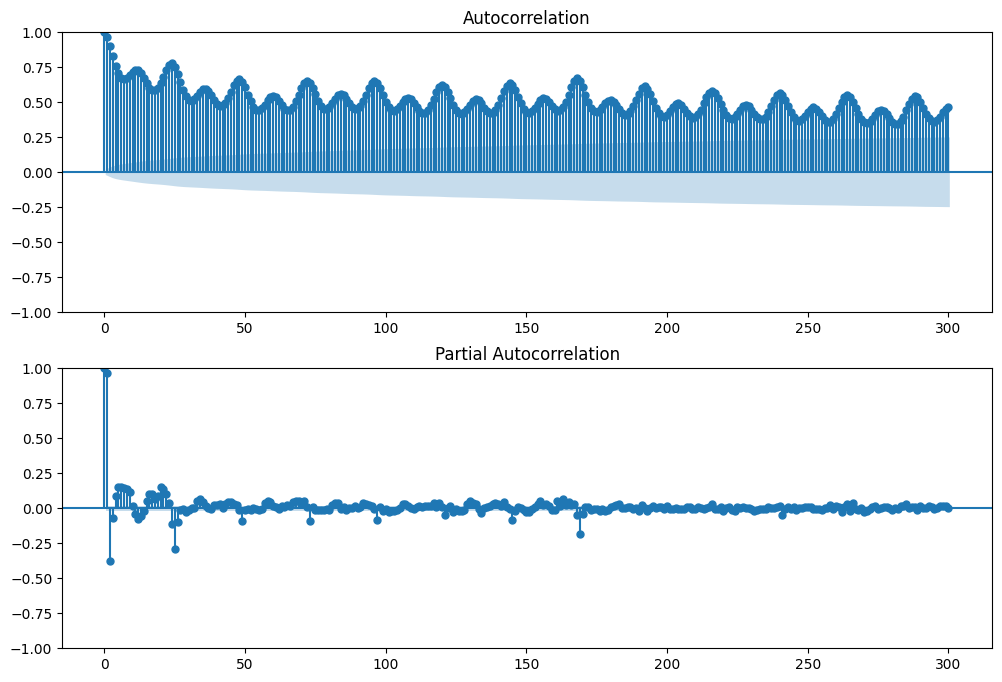

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Time series: ACF and PACF
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# for 'price'
plot_acf(train_df, lags=300, ax=axs[0])
plot_pacf(train_df, lags=300, ax=axs[1])

plt.show()

In [47]:
# Validation set: 3 months
validation_df = df.loc['2019-05-01 00:00':'2019-07-31 23:00']
validation_spot = validation_df.values
validation_df

,price
datetime,
2019-05-01 00:00:00,57.63
2019-05-01 01:00:00,56.56
2019-05-01 02:00:00,55.52
2019-05-01 03:00:00,55.71
2019-05-01 04:00:00,55.00
...,...
2019-07-31 19:00:00,48.79
2019-07-31 20:00:00,48.17
2019-07-31 21:00:00,48.79


In [48]:
# Test set: 3 months
test_df = df.loc['2019-08-07 00:00':'2019-10-30 23:00']
test_spot = test_df.values
test_df

,price
datetime,
2019-08-07 00:00:00,49.76
2019-08-07 01:00:00,46.21
2019-08-07 02:00:00,43.51
2019-08-07 03:00:00,41.75
2019-08-07 04:00:00,42.80
...,...
2019-10-30 19:00:00,60.00
2019-10-30 20:00:00,56.85
2019-10-30 21:00:00,55.50


In [49]:
from sklearn.preprocessing import MinMaxScaler

# Declaration of the scaler
scaler_price = MinMaxScaler(feature_range=(0, 1))

# Scaler is fitted with the training data
scaler_price.fit(train_df[["price"]])

# Applying scaler to the 'price' column for each set
train_df.loc[:, "price"] = scaler_price.transform(train_df[["price"]])
validation_df.loc[:, "price"] = scaler_price.transform(validation_df[["price"]])
test_df.loc[:, "price"] = scaler_price.transform(test_df[["price"]])

<ipython-input-49-7fe8e00f35ca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, "price"] = scaler_price.transform(train_df[["price"]])
<ipython-input-49-7fe8e00f35ca>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df.loc[:, "price"] = scaler_price.transform(validation_df[["price"]])
<ipython-input-49-7fe8e00f35ca>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [50]:
def create_windows(df, window_size=168, forecast_size=24):
    input_data, output_data = [], []

    # Step through the dataframe with a step size of 168 (7*24)
    for i in range(window_size, len(df) - forecast_size + 1, window_size):
        inputs = df.iloc[i-window_size:i]["price"].values
        outputs = df.iloc[i:i+forecast_size]["price"].values
        input_data.append(inputs)
        output_data.append(outputs)

    return np.array(input_data), np.array(output_data)

window_size = 168
forecast_size = 24

X_train, Y_train = create_windows(train_df, window_size, forecast_size)
X_validation, Y_validation = create_windows(validation_df, window_size, forecast_size)
X_test, Y_test = create_windows(test_df, window_size, forecast_size)

In [51]:
X_train.shape

(59, 168)

In [52]:
Y_train.shape

(59, 24)

In [53]:
X_validation.shape

(13, 168)

In [54]:
X_test.shape

(12, 168)

In [55]:
# Converting the arrays to PyTorch tensors and moving them to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).unsqueeze(-1).float().to(device)
Y_train_tensor = torch.tensor(Y_train).unsqueeze(-1).float().to(device)
X_train_tensor = torch.tensor(X_train).float().to(device)  # Reshape to (batch_size, sequence_length, number_of_features)
Y_train_tensor = torch.tensor(Y_train).float().to(device)
X_val_tensor = torch.tensor(X_validation).unsqueeze(-1).float().to(device)
Y_val_tensor = torch.tensor(Y_validation).unsqueeze(-1).float().to(device)
X_val_tensor = torch.tensor(X_validation).float().to(device)  # Reshape to (batch_size, sequence_length, number_of_features)
Y_val_tensor = torch.tensor(Y_validation).float().to(device)

In [56]:
X_train_tensor.shape

torch.Size([59, 168])

In [57]:
Y_train_tensor.shape

torch.Size([59, 24])

In [69]:
# Model definition
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_layer_neurons, output_size):
        super(MLPModel, self).__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_size, hidden_layer_neurons),
            nn.BatchNorm1d(hidden_layer_neurons),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(hidden_layer_neurons, hidden_layer_neurons),
            nn.BatchNorm1d(hidden_layer_neurons),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(hidden_layer_neurons, hidden_layer_neurons),
            nn.BatchNorm1d(hidden_layer_neurons),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(hidden_layer_neurons, hidden_layer_neurons),
            nn.BatchNorm1d(hidden_layer_neurons),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(hidden_layer_neurons, output_size),
        )

    def forward(self, x):
        x = self.mlp(x)
        return x

In [70]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=100, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt') # <-- saves model to disk
        self.val_loss_min = val_loss

In [71]:
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt

hidden_size = 120
# MLP model
model = MLPModel(input_size=X_train.shape[1], hidden_layer_neurons=hidden_size, output_size=24)

# Loss function: MAE
loss_fn = nn.L1Loss()

# Optimizer
LR_INICIO = 1e-1  # initial learning rate
LR_FINAL = 1e-3  # final learning rate
LR_EPOCHS = 2000  # total number of epochs
optimizer = optim.SGD(model.parameters(), lr=LR_INICIO, momentum=0.9)

# Learning rate scheduler
lr_lambda = lambda epoch: LR_FINAL / LR_INICIO * (LR_INICIO / LR_FINAL)**(1 - epoch / LR_EPOCHS)
scheduler = LambdaLR(optimizer, lr_lambda)

# EarlyStopping class
early_stopping = EarlyStopping(patience=500, verbose=True)

# To track loss history
loss_history = []
val_loss_history = []

# Training loop
for epoch in range(LR_EPOCHS):
    optimizer.zero_grad()  # Reset gradients

    # Forward pass
    output = model(X_train_tensor)
    loss = loss_fn(output, Y_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Update learning rate
    scheduler.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = loss_fn(val_outputs, Y_val_tensor)

    print(f"Epoch {epoch+1}, Learning Rate: {scheduler.get_last_lr()[0]}, Loss: {loss.item()}, Val Loss: {val_loss.item()}")

    # Append loss values
    loss_history.append(loss.item())
    val_loss_history.append(val_loss.item())

    # Early stopping check
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

Epoch 1, Learning Rate: 0.09977000638225536, Loss: 0.7084391117095947, Val Loss: 0.5695024132728577
Validation loss decreased (inf --> 0.569502).  Saving model ...
Epoch 2, Learning Rate: 0.0995405417351527, Loss: 0.6760777831077576, Val Loss: 0.555400550365448
Validation loss decreased (0.569502 --> 0.555401).  Saving model ...
Epoch 3, Learning Rate: 0.0993116048420934, Loss: 0.6615760326385498, Val Loss: 0.534756064414978
Validation loss decreased (0.555401 --> 0.534756).  Saving model ...
Epoch 4, Learning Rate: 0.09908319448927676, Loss: 0.6403848528862, Val Loss: 0.5073933005332947
Validation loss decreased (0.534756 --> 0.507393).  Saving model ...
Epoch 5, Learning Rate: 0.09885530946569392, Loss: 0.612327516078949, Val Loss: 0.4733448624610901
Validation loss decreased (0.507393 --> 0.473345).  Saving model ...
Epoch 6, Learning Rate: 0.09862794856312107, Loss: 0.5773107409477234, Val Loss: 0.4304090738296509
Validation loss decreased (0.473345 --> 0.430409).  Saving model ...

<All keys matched successfully>

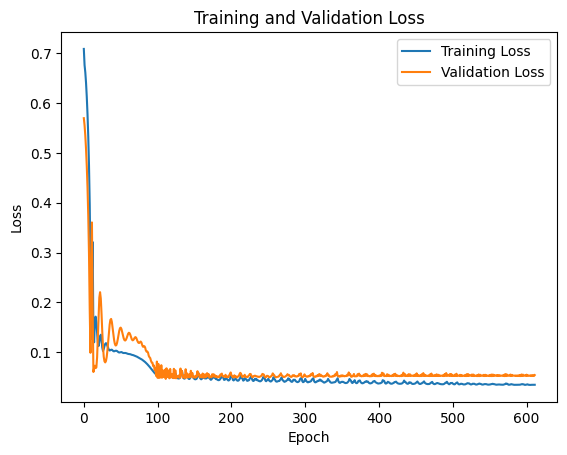

In [72]:
# Loss history
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [73]:
# Calling the MLP model and loading the saved weights
model = MLPModel(input_size=X_train.shape[1], hidden_layer_neurons=hidden_size, output_size=24)
model.load_state_dict(torch.load('checkpoint.pt'))

# Move the model to the appropriate device
model = model.to(device)

# Test data to tensor and moving it to the appropriate device
X_test_tensor = torch.tensor(X_test).float().to(device)

# Evaluation mode
model.eval()

# Forecasting on the test set
with torch.no_grad():
    test_predictions = model(X_test_tensor)

In [74]:
# Predictions to a numpy array
test_predictions_np = test_predictions.numpy()

# Empty array to hold the inverse-transformed predictions
predictions = np.empty_like(test_predictions_np)

# Inverse-transform each prediction separately
for i in range(test_predictions_np.shape[1]):
    predictions[:, i] = scaler_price.inverse_transform(test_predictions_np[:, i:i+1]).flatten()

In [75]:
# Empty array to hold the inverse-transformed labels
y_test = np.empty_like(Y_test)

# Inverse-transform each label separately
for i in range(Y_test.shape[1]):
    y_test[:, i] = scaler_price.inverse_transform(Y_test[:, i:i+1]).flatten()

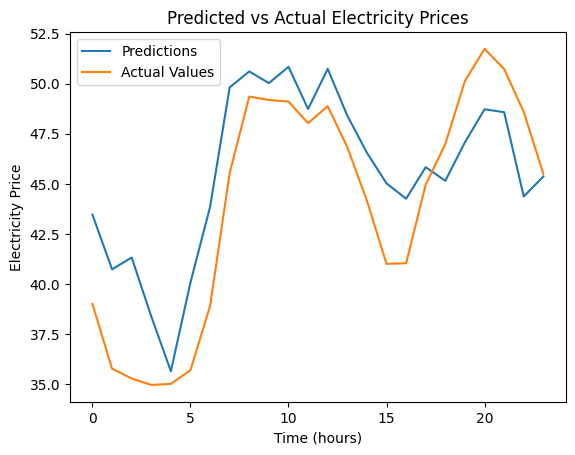

In [76]:
# Figure and axes for the plot
fig, ax = plt.subplots()

# Predictions and actual values
ax.plot(predictions[6], label='Predictions')
ax.plot(y_test[6], label='Actual Values')

# Legend and labels to the plot
ax.legend()
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Electricity Price')
ax.set_title('Predicted vs Actual Electricity Prices')

# Plot
plt.show()

In [77]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("MSE: ", mse)
print("MAE: ", mae)

MSE:  28.459163895997182
MAE:  4.322586065398322


In [78]:
# Histogram of residuals
def residual_histogram(y_true, y_pred, step):
    # copy of the input lists
    true = y_true[:]
    pred = y_pred[:]
    # empty list to allocate residuals
    residual = []
    if len(true) ==len(pred):
        for cicle in range(len(true)):
            for item in range(len(true[cicle])):
                residual.append(true[cicle][item] - pred[cicle][item])

    minim = min(residual)
    maxim = max(residual)

    bins = int(abs((maxim - minim) / step))

    df = pd.DataFrame(residual)
    hist = df.hist(bins = bins)
    return residual

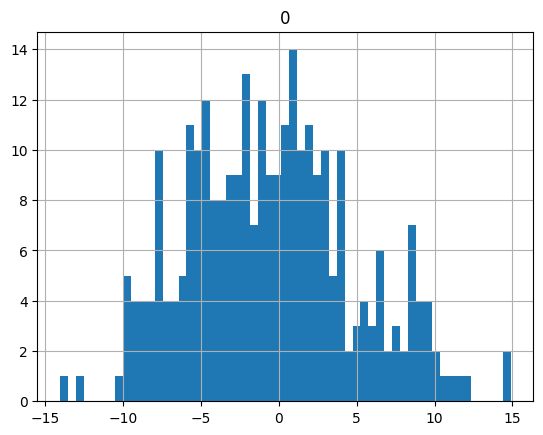

In [79]:
residuals = residual_histogram(y_test, predictions, 0.5)